### Image processing part

In [2]:
from skimage import io, filters
import matplotlib.pyplot as plt
import numpy as np

**Example image read as grayscale**

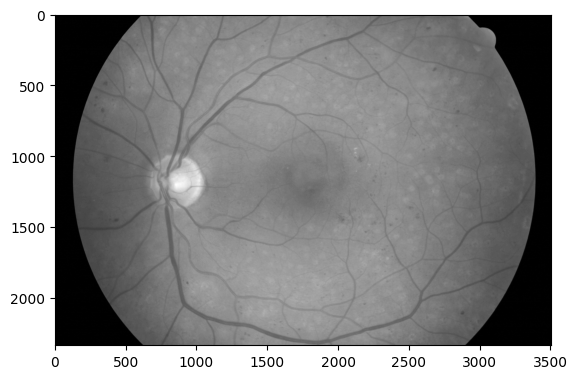

In [3]:
image = io.imread("original_images/image1.JPG", as_gray=True)
plt.imshow(image, cmap='gray')

**Display comparison of rgb channels**

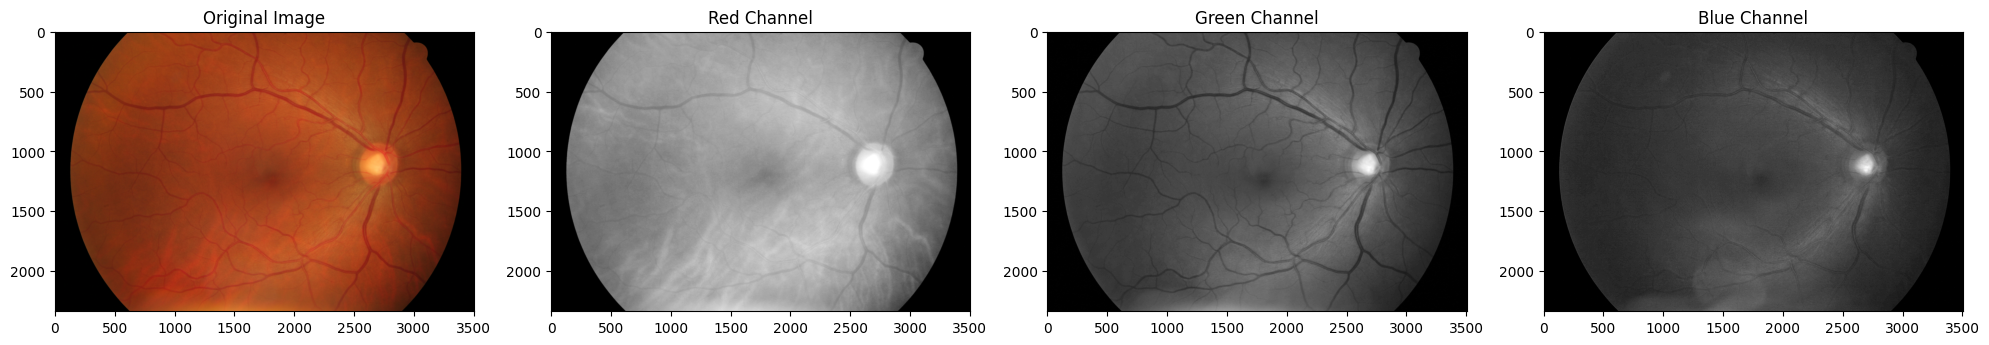

In [42]:
image_path = 'images/15_h.jpg'
gold_standard_path = 'manual1/15_h.tif'
mask_path = 'mask/15_h_mask.tif'

image = io.imread(image_path)

# Separate the color channels
red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]

# Display the original and separated channels
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
ax = axes.ravel()

ax[0].imshow(image)
ax[0].set_title('Original Image')

ax[1].imshow(red_channel, cmap='gray')
ax[1].set_title('Red Channel')

ax[2].imshow(green_channel, cmap='gray')
ax[2].set_title('Green Channel')

ax[3].imshow(blue_channel, cmap='gray')
ax[3].set_title('Blue Channel')
plt.tight_layout()

**Apply gaussian and frangi filters**

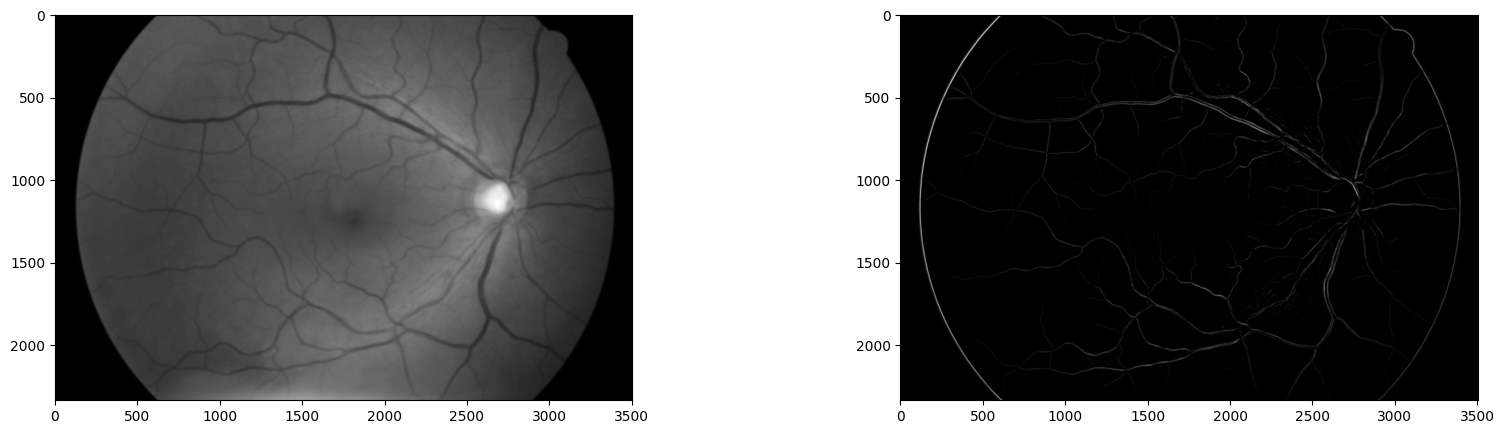

In [43]:
blurred_green = filters.gaussian(green_channel, sigma=5)
filtered_green = filters.frangi(blurred_green)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
ax = axes.ravel()

ax[0].imshow(blurred_green, cmap='gray')
ax[1].imshow(filtered_green, cmap='gray')

**Comparison of frangi performance based on sigma value in gaussian filter**

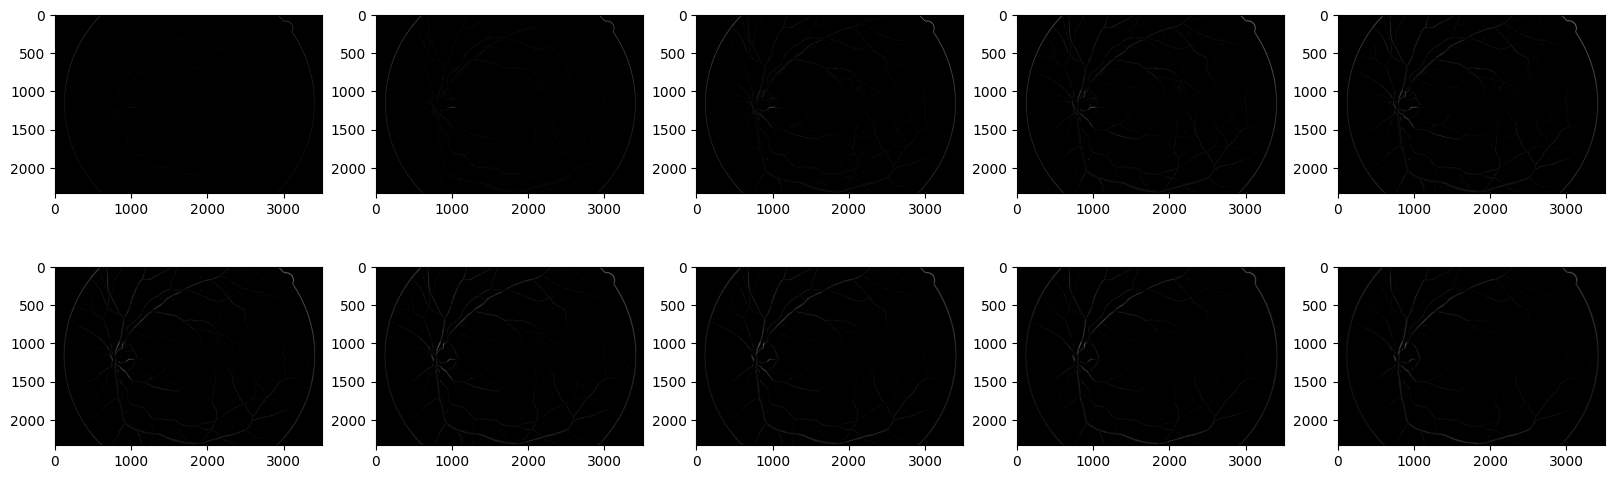

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(20, 6))

for i in range(10):
    # Sprawdzamy jak wygląda obraz dla różnej wartości odchylenia standardowego oraz po użyciu filtru frangi'ego
    gaussian_filtered = filters.gaussian(green_channel, sigma=i+1)
    frangi_filtered = filters.frangi(gaussian_filtered)
    if i < 5: ax[0][i%5].imshow(frangi_filtered, cmap='gray')
    if i >= 5: ax[1][i%5].imshow(frangi_filtered, cmap='gray')

**Scale image to 0, 1 pixel values range**

In [44]:
from sklearn.preprocessing import MinMaxScaler

def scale_to_zero_to_one_range(image):
    # Flatten image
    image_reshaped = image.reshape(-1, 1)
    
    # Scale to 0-1 range
    scaler = MinMaxScaler(feature_range=(0, 1))
    image_scaled_reshaped = scaler.fit_transform(image_reshaped)

    # Transform back to original shape
    image_scaled = image_scaled_reshaped.reshape(image.shape)

    return image_scaled


In [45]:
image = filtered_green.copy()
image_scaled = scale_to_zero_to_one_range(image)

print(np.min(image), np.max(image))
print(np.min(image_scaled), np.max(image_scaled))

0.0 0.7509739333881243
0.0 0.9999999999999999


**Apply mask**

2


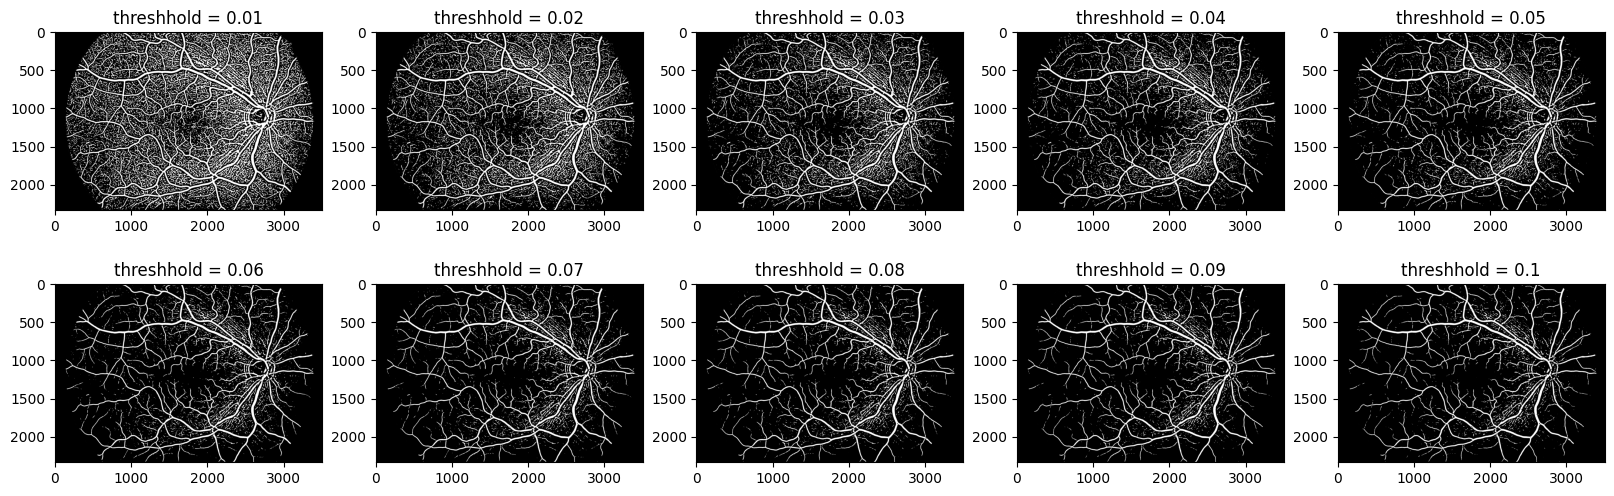

In [46]:
from skimage.color import rgb2gray
import tifffile
mask = tifffile.imread(mask_path)
grayscale_mask = rgb2gray(mask)
print(grayscale_mask.ndim)

# Przeskalowanie maski
mask = scale_to_zero_to_one_range(grayscale_mask)

res = np.zeros(mask.shape)
for i in range(len(res)):
    for j in range(len(res[0])):
        if mask[i][j] == 1: res[i][j] = image_scaled[i][j]

fig, ax = plt.subplots(2, 5, figsize=(20, 6))

for i in range(10):
    threshholded_image = res > 0.001 * (i+1)
    if i < 5: 
        ax[0][i%5].imshow(threshholded_image, cmap='gray')
        ax[0][i%5].set_title(f'threshhold = {(i+1)*0.01}')
    if i >= 5: 
        ax[1][i%5].imshow(threshholded_image, cmap='gray')
        ax[1][i%5].set_title(f'threshhold = {(i+1)*0.01}')

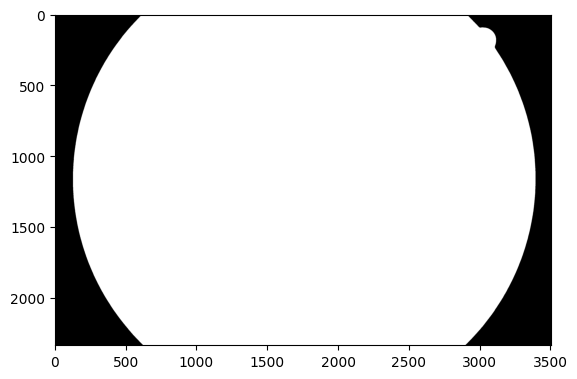

In [9]:
plt.imshow(mask, cmap='gray')

**Apply threshholding**

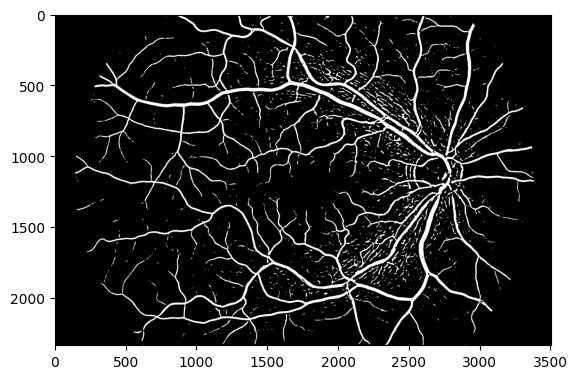

In [58]:
threshholded_image = res > 0.01
threshholded_image = threshholded_image.astype(int)
plt.imshow(threshholded_image, cmap='gray')

**Apply median filter to remove noise**

In [59]:
from skimage.filters import median
without_noise = median(threshholded_image)

**Compare result with gold standard and display statistics**

In [60]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

def print_evaluation_metrics_raport(image_true, image_predicted):
    print(f"Accuracy: {accuracy_score(image_true.flatten(), image_predicted.flatten())}")
    print(f"Recall: {recall_score(image_true.flatten(), image_predicted.flatten())}")
    print(f"Specificity: {recall_score(image_true.flatten(), image_predicted.flatten(), pos_label=0)}")
    print(f"Precision: {precision_score(image_true.flatten(), image_predicted.flatten())}")

In [61]:
gold_standard = io.imread(gold_standard_path)
gold_standard = scale_to_zero_to_one_range(gold_standard)

print("Metrics for thresholded image:")
print_evaluation_metrics_raport(gold_standard, threshholded_image)

print("Metrics for thresholded image with median filter:")
print_evaluation_metrics_raport(gold_standard, without_noise)

Metrics for thresholded image:
Accuracy: 0.9638285208294239
Recall: 0.8549743077918737
Specificity: 0.9730810796623958
Precision: 0.729706239759785
Metrics for thresholded image with median filter:
Accuracy: 0.9642699195049103
Recall: 0.8549867835226785
Specificity: 0.9735589365940187
Precision: 0.7332272344295401


**Processed image vs gold standard**

Text(0.5, 1.0, 'Gold standard')

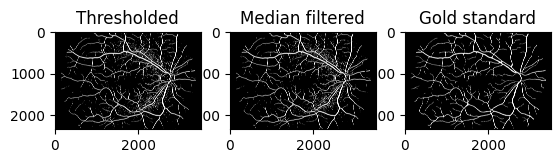

In [62]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(threshholded_image, cmap='gray')
ax[0].set_title("Thresholded")
ax[1].imshow(without_noise, cmap='gray')
ax[1].set_title("Median filtered")
ax[2].imshow(gold_standard, cmap='gray')
ax[2].set_title("Gold standard")

## Machine learning part

**Example split into 5x5 fragments**

In [31]:
from skimage.util.shape import view_as_windows
from skimage import io
from skimage.filters import sobel

img = io.imread('manual1/04_h.tif')
img = scale_to_zero_to_one_range(img)
img_5_5_blocks = view_as_windows(img, (5, 5))
print(type(img_5_5_blocks))
print(img_5_5_blocks.shape)
print(img.shape)
print(img_5_5_blocks[0][0])


<class 'numpy.ndarray'>
(2332, 3500, 5, 5)
(2336, 3504)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


**Create data and split into training and test sets**

In [32]:
def calculate_features(patch):
    flattened_patch = patch.flatten()
    average = np.mean(flattened_patch)
    stdev = np.std(flattened_patch)
    median = np.median(flattened_patch)
    min = np.min(flattened_patch)
    max = np.max(flattened_patch)
    range = max - min
    sobel_image = sobel(patch)
    sobel_mean = np.mean(sobel_image)
    sobel_stdev = np.std(sobel_image)
    sobel_max = np.max(sobel_image)
    
    feature_vector = [
        average, stdev, median, min, max, range, 
        sobel_mean, sobel_stdev, sobel_max
    ]

    return feature_vector

def get_green_channel(image):
    return image[:, :, 1]

def split_image_into_patches(image, n):
    padded_image = np.pad(image, (n - 1) // 2)
    patches = view_as_windows(padded_image, (n, n))
    new_dim_size = patches.shape[0] * patches.shape[1]
    return patches.reshape((new_dim_size, 5, 5))

In [34]:
import os
from sklearn.model_selection import train_test_split
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

images = [os.path.join('images',file) for file in os.listdir('images')]
expert_masks = [os.path.join('manual1',file) for file in os.listdir('manual1')]

data = []
labels = []
DATASET_SIZE = 1_000_000
NO_IMAGES = len(images) - 1
FRAGMENTS_PER_IMAGE = DATASET_SIZE//NO_IMAGES
# images_indices = random.sample(range(len(images)), k=NO_IMAGES)

PATCH_SIZE = 5

for i in range(len(images)):
    image = io.imread(images[i])
    image = scale_to_zero_to_one_range(image)
    image = get_green_channel(image)
    image_patches = split_image_into_patches(image, PATCH_SIZE)
    
    mask = io.imread(expert_masks[i], as_gray=True)
    mask = scale_to_zero_to_one_range(mask)
    masks_patches = split_image_into_patches(mask, PATCH_SIZE)

    fragments_indices = random.sample(range(len(image_patches)), FRAGMENTS_PER_IMAGE)
    for frag_idx in fragments_indices:
        curr_img = image_patches[frag_idx]
        curr_mask = masks_patches[frag_idx]
        feature_vector = calculate_features(curr_img)
        central_pixel = curr_mask[2][2]

        if central_pixel == 0.0 or central_pixel == 1.0:
            data.append(feature_vector)
            labels.append(central_pixel)

# Undersampling
print('Training labels %s' % Counter(labels))
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_res, y_res = rus.fit_resample(data, labels)
print('Training labels after undersampling %s' % Counter(y_res))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, stratify=y_res, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

# Train model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Predict for test data
y_pred = rfc.predict(X_test)

print(classification_report(y_test, y_pred))

Training labels Counter({0.0: 943582, 1.0: 79125})
Training labels after undersampling Counter({0.0: 79125, 1.0: 79125})
126600 31650
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77     15825
         1.0       0.77      0.75      0.76     15825

    accuracy                           0.76     31650
   macro avg       0.76      0.76      0.76     31650
weighted avg       0.76      0.76      0.76     31650



In [20]:
print_evaluation_metrics_raport(np.array(y_test), np.array(y_pred))

Accuracy: 0.7800274312585723
Recall: 0.7531186728495852
Specificity: 0.8069361896675593
Precision: 0.7959549941326707


**Test our model on new image**

(8185344, 5, 5)
finished creating metrics
staring predicting
finished predicting


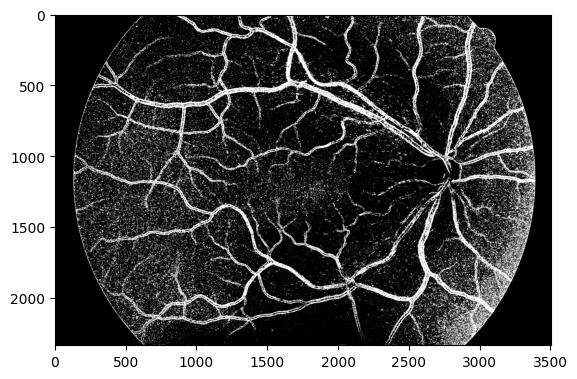

In [35]:
new_image = io.imread(images[-1])
new_image = scale_to_zero_to_one_range(new_image)
new_image = get_green_channel(new_image)
patches = split_image_into_patches(new_image, 5)
print(patches.shape)
metrics = []
for i, patch in enumerate(patches):
    feature_vector = calculate_features(patch)
    metrics.append(feature_vector)

print('finished creating metrics')
print('staring predicting')
prediction = rfc.predict(metrics)
predicted_image = prediction.reshape(new_image.shape[0], new_image.shape[1])
print('finished predicting')
plt.imshow(predicted_image, cmap='gray')

In [37]:
gold_standard = io.imread(expert_masks[-1])
gold_standard = scale_to_zero_to_one_range(gold_standard)
print(classification_report(gold_standard.flatten(), predicted_image.flatten()))

              precision    recall  f1-score   support

         0.0       0.97      0.87      0.92   7544099
         1.0       0.30      0.64      0.41    641245

    accuracy                           0.85   8185344
   macro avg       0.63      0.76      0.66   8185344
weighted avg       0.91      0.85      0.88   8185344



**Gold standard vs predicted image**

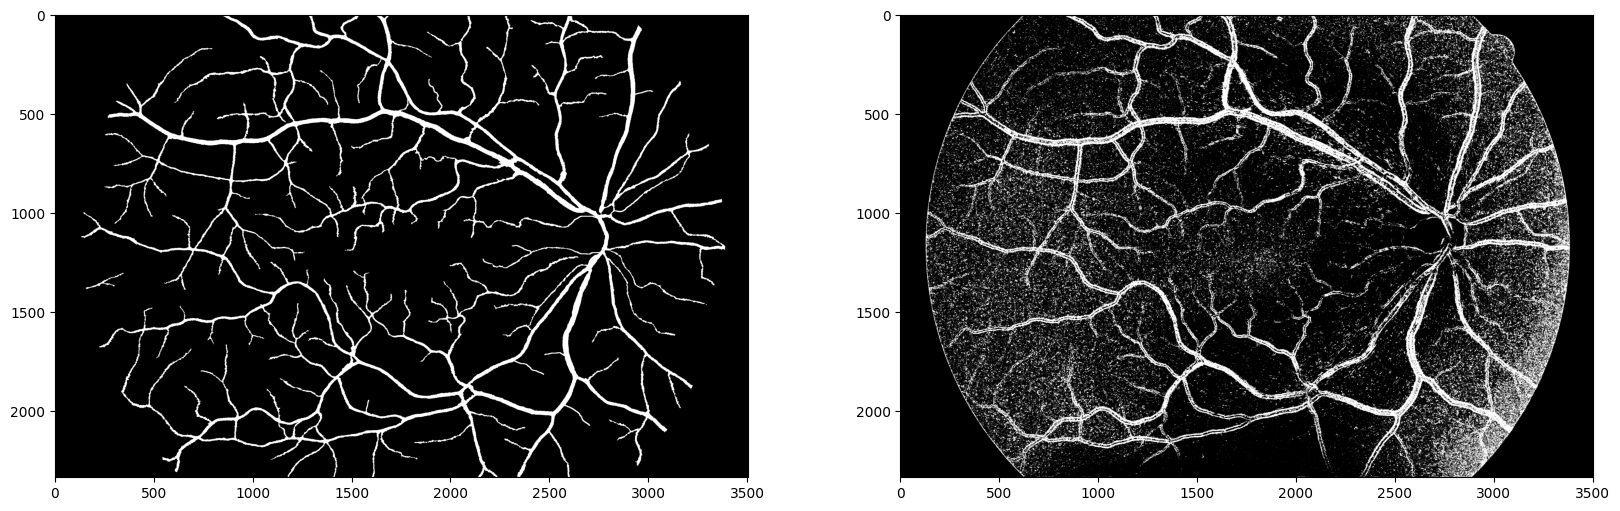

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].imshow(gold_standard, cmap='gray')
ax[1].imshow(predicted_image, cmap='gray')

**Calculate and display statistics**

**Gold standard vs processed image vs machine learning**

[(-0.5, 3503.5, 2335.5, -0.5),
 (-0.5, 3503.5, 2335.5, -0.5),
 (-0.5, 3503.5, 2335.5, -0.5)]

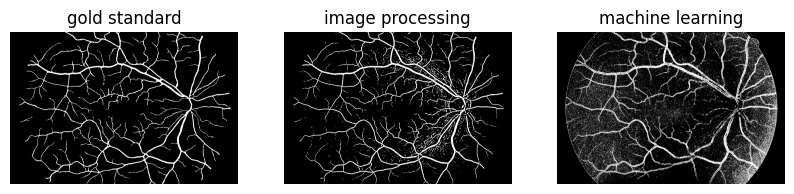

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(10, 20))

ax[0].imshow(gold_standard, cmap='gray')
ax[0].set_title('gold standard')
ax[1].imshow(threshholded_image, cmap='gray')
ax[1].set_title('image processing')
ax[2].imshow(predicted_image, cmap='gray')
ax[2].set_title('machine learning')
[ax[i].axis('off') for i in range(3)]

**Display statistics for comparison**

In [82]:
from tabulate import tabulate

image_processing_eval_metrics = classification_report(gold_standard.flatten(), threshholded_image.flatten(), output_dict=True)
ml_eval_metrics = classification_report(gold_standard.flatten(), predicted_image.flatten(), output_dict=True)

table_data = [
    ["precision", round(image_processing_eval_metrics['1.0']['precision']*100, 2), round(ml_eval_metrics['1.0']['precision']*100, 2)],
    ["recall", round(image_processing_eval_metrics['1.0']['recall']*100,2), round(ml_eval_metrics['1.0']['recall']*100,2)],
    ["specificity", round(image_processing_eval_metrics['0.0']['recall']*100,2), round(ml_eval_metrics['0.0']['recall']*100,2)],
    ["accuracy", round(image_processing_eval_metrics['accuracy']*100,2), round(ml_eval_metrics['accuracy']*100,2)]
]

headers = ["metric", "image processing", "machine learning"]

print(tabulate(table_data, headers=headers, tablefmt="grid"))

+-------------+--------------------+--------------------+
| metric      |   image processing |   machine learning |
+=============+====================+====================+
| precision   |              72.97 |              29.88 |
+-------------+--------------------+--------------------+
| recall      |              85.5  |              63.84 |
+-------------+--------------------+--------------------+
| specificity |              97.31 |              87.27 |
+-------------+--------------------+--------------------+
| accuracy    |              96.38 |              85.43 |
+-------------+--------------------+--------------------+
